## Chapter 7

### Algorithm Examples

In [219]:
from importlib import reload
import utilities as utils
reload(utils)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy import stats

stopping criteria met after 4 iterations.


In [90]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

stopping criteria met after 16 iterations.


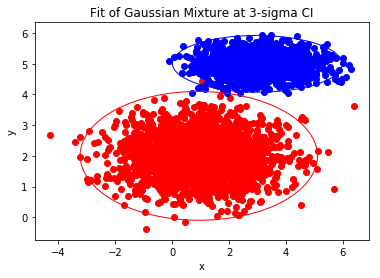

Final Results
Cluster 0:
  lambda_k: 0.44533455522096704
  mu_k: [0.93870251 1.99969145]
  Sigma_k: [[ 1.93249344 -0.00414751]
 [-0.00414751  0.48867021]]
Cluster 1:
  lambda_k: 0.5546654447790317
  mu_k: [2.99504326 4.99625191]
  Sigma_k: [[ 0.98911364 -0.00339379]
 [-0.00339379  0.09477448]]


In [91]:
rng = np.random.RandomState(seed=0)
mu1 = np.array([1., 2.])
cov1 = np.array([[2., 0.], [0., .5]])
mu2 = np.array([3., 5.])
cov2 = np.array([[1., 0.], [0., .1]])

num_data_pts = np.array([2000, 2500])
X = np.vstack((rng.multivariate_normal(mu1, cov1, num_data_pts[0]), rng.multivariate_normal(mu2, cov2, num_data_pts[1])))
_lambdas, mus, Sigmas = utils.fit_gaussian_mixture(X, 2, stopping_thresh=1e-4)

plt.figure()
plt.scatter(X[:num_data_pts[0], 0], X[:num_data_pts[0], 1],c='r')
plt.scatter(X[num_data_pts[1]:, 0], X[num_data_pts[1]:, 1],c='b')
ax = plt.gca()

nstd = 3

_c = 'rb'
for k in range(_lambdas.size):
    vals, vecs = eigsorted(Sigmas[k, :, :])
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(mus[k, 0], mus[k, 1]),
              width=w, height=h,
              angle=theta, edgecolor=_c[k], facecolor='none')
    ax.add_patch(ell)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit of Gaussian Mixture at 3-sigma CI')
plt.show()

print("Final Results")
for k in range(len(_lambdas)):
    print("Cluster {}:".format(k))
    print("  lambda_k: {}".format(_lambdas[k]))
    print("  mu_k: {}".format(mus[k, :]))
    print("  Sigma_k: {}".format(Sigmas[k, :, :]))

stopping criteria met after 2 iterations.
stopping criteria met after 2 iterations.
stopping criteria met after 4 iterations.


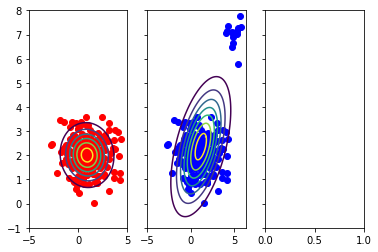

[[1.1842754  2.35925102]]
[[4.35642531 4.08544943]
 [4.08544943 7.64591286]]
[2.67668653e+08]


In [217]:
rng = np.random.RandomState(seed=0)
mu1 = np.array([1., 2.])
cov1 = np.array([[2., 0.], [0., .5]])
num_data_pts = np.array([200])
X = rng.multivariate_normal(mu1, cov1, num_data_pts[0])
num_outliers = 15
outliers_mu = np.array([5., 7.])
outliers_Sigma = np.array([[.2, 0.], [0., .2]])
X_with_outliers = np.vstack((X, rng.multivariate_normal(outliers_mu, outliers_Sigma, num_outliers)))

lambda1, _mu1, _Sigma1 = utils.fit_gaussian_mixture(X, 1)
lambdao, _muo, _Sigmao = utils.fit_gaussian_mixture(X_with_outliers, 1)

t_mu, t_sig, t_nu = utils.fit_student_distribution(X_with_outliers, stopping_thresh=1e-6)

#Creates two subplots and unpacks the output array immediately
x = np.linspace(-5, 5, 100).reshape((100, 1))
y = np.linspace(-1, 8, 100).reshape((100, 1))
[XX, YY] = np.meshgrid(x, y)
xx = XX.flatten().reshape((xx.size, 1))
yy = YY.flatten().reshape((yy.size, 1))
xy = np.hstack((xx, yy))
temp = stats.multivariate_normal.pdf(xy, _mu1[0, :], _Sigma1[0, :, :])
gauss1 = temp.reshape((100, 100))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.scatter(X[:, 0], X[:, 1],c='r')
ax1.contour(XX, YY, gauss1)

ax2.scatter(X_with_outliers[:, 0], X_with_outliers[:, 1],c='b')
temp = stats.multivariate_normal.pdf(xy, _muo[0, :], _Sigmao[0, :, :])
gauss2 = temp.reshape((100, 100))
ax2.contour(XX, YY, gauss2)

ax2.scatter(X_with_outliers[:, 0], X_with_outliers[:, 1],c='b')
temp = stats.multivariate_normal.pdf(xy, _muo[0, :], _Sigmao[0, :, :])
gauss2 = temp.reshape((100, 100))
ax2.contour(XX, YY, gauss2)

plt.show()

### Problem 1

Identify the class conditional probability densities: $Pr(x = x^* \ | \ w=\text{unripe})$ and $Pr(x = x^* \ | \ w=\text{ripe})$.  The class conditional probability densities should be constructed with the following facts in mind:

* The conditional densities may be multimodal.  Evaluation of the distribution of the data will tell how many bases are required to best model the data
* There may be outliers in one or both of the conditional densities.  Exploratory analysis of the data will indicate if this is the case or not.
* The data $x$ is low-dimensional, so factor analysis is unnecessary.

With these facts in mind, the best choice would be to consider a _robust mixture model_; see Figure 7.3.  The choice and parameterization of student-t densities required to represent the class conditional densities can be constructed using the EM algorithm.  Now, given modeled representations of $Pr(x = x^* \ | \ w=\text{unripe})$ and $Pr(x = x^* \ | \ w=\text{ripe})$, we can use this information to complete our classifier:

\begin{eqnarray}
Pr(w=\text{unripe} \ | \ x = x^*) &=& \frac{Pr(x = x^* \ | \ w=\text{unripe})Pr(w=\text{unripe})}{Pr(x = x^* \ | \ w=\text{unripe})Pr(w=\text{unripe}) + Pr(x = x^* \ | \ w=\text{ripe})Pr(w=\text{ripe})} \\
Pr(w=\text{ripe} \ | \ x = x^*) &=& \frac{Pr(x = x^* \ | \ w=\text{ripe})Pr(w=\text{ripe})}{Pr(x = x^* \ | \ w=\text{unripe})Pr(w=\text{unripe}) + Pr(x = x^* \ | \ w=\text{ripe})Pr(w=\text{ripe})}
\end{eqnarray}

The only remaining consideration is the prior density over the world state.  This can be represented by a Bernoulli distribution with the parameter $\lambda$ chosen to either reflect empirical data (e.g. from a training set) or equal likelihood ($\lambda = 0.5$).

### Problem 2

Misrepresentation of labels in the underlying dataset would appear as outliers in the class conditional densities.  Representation of these densities as student-t distributions could help mitigate the effect of these outliers.

_As an aside: If you, as the data scientist, are aware that there are issues with the underlying data, you should probably retrain your model with the appropriate label corrections applied!_ 

### Problem 3

The density of the hidden variable $q_i(\mathbf{h}_i)$:

\begin{eqnarray}
q_i(\mathbf{h}_i) &=& \frac{\lambda_k \text{Norm}_{\mathbf{x}_i} [\mathbf{\mu}_k, \Sigma_k]}{\sum_{j=1}^K \lambda_j \text{Norm}_{\mathbf{x}_i} [\mathbf{\mu}_j, \Sigma_j]} \\
&\triangleq& r_{ik}
\end{eqnarray}

The log-likelihood, with Lagrange-multiplier for the constraint $\sum_{j=1}^k \lambda_j = 1$, is:
\begin{eqnarray}
L = \sum_{i=1}^I r_{ik} \bigl [ \log \lambda_k - 0.5 (\mathbf{x}_i - \mathbf{\mu}_k)^T \Sigma_k^{-1} (\mathbf{x}_i - \mathbf{\mu}_k) \bigr ]
\end{eqnarray}

_Before differentiation of $L$, note that $r_{ik}$ is constant during the M step of the EM algorithm!_

Take the derivatives and find values that make them vanish:
\begin{eqnarray}
0 &=& \frac{\partial L}{\partial \mathbf{\mu}_k} \\
&=& \sum_{i=1}^I r_{ik} \Sigma_k^{-1} (\mathbf{x}_i - \mathbf{\hat \mu}_k) \\
\sum_{i=1}^I r_{ik} \mathbf{\hat \mu}_k &=& \sum_{i=1}^I r_{ik} \mathbf{x}_i \\
\mathbf{\hat \mu}_k &=& \frac{\sum_{i=1}^I r_{ik} \mathbf{x}_i}{\sum_{i=1}^I r_{ik}} \\
0 &=& \frac{\partial L}{\partial \Sigma_k} \\
\text{see Appendix C.38} &=& \sum_{i=1}^I -0.5 r_{ik} \bigl [\hat \Sigma_k^{-T} - \hat \Sigma_k^{-2} (\mathbf{x}_i - \mathbf{\hat \mu}_k) (\mathbf{x}_i - \mathbf{\hat \mu}_k)^T \bigr ] \\
\hat \Sigma_k^{-1} \sum_{i=1}^I r_{ik} &=& \hat \Sigma_k^{-2} \sum_{i=1}^I r_{ik} (\mathbf{x}_i - \mathbf{\hat \mu}_k) (\mathbf{x}_i - \mathbf{\hat \mu}_k)^T \\
\hat \Sigma_k &=& \frac{\sum_{i=1}^I r_{ik} (\mathbf{x}_i - \mathbf{\hat \mu}_k) (\mathbf{x}_i - \mathbf{\hat \mu}_k)^T}{\sum_{i=1}^I r_{ik}} \\
0 &=& \frac{\partial L}{\partial \lambda_k} \\
&=& \sum_{i=1}^I \frac{r_{ik}}{\hat \lambda_k} + \nu \\
0 &=& \sum_{i=1}^I r_{ik} + \nu \hat \lambda_k \\
\text{(must hold for all $k$)} \ \ \nu \sum_{j=1}^K \hat \lambda_j + \sum_{j=1}^K \sum_{i=1}^I r_{ij} &=& 0 \\
\nu \cdot 1 + \sum_{j=1}^K \sum_{i=1}^I r_{ij} &=& 0 \\
\nu &=& -\sum_{j=1}^K \sum_{i=1}^I r_{ij} \\
0 &=& \sum_{i=1}^I r_{ik} + \nu \hat \lambda_k \\
&=& \sum_{i=1}^I r_{ik} -\sum_{j=1}^K \sum_{i=1}^I r_{ij} \hat \lambda_k \\
\sum_{j=1}^K \sum_{i=1}^I r_{ij} \hat \lambda_k &=& \sum_{i=1}^I r_{ik} \\
\hat \lambda_k &=& \frac{\sum_{i=1}^I r_{ik}}{\sum_{j=1}^K \sum_{i=1}^I r_{ij}}
\end{eqnarray}

The optimal values for the M step are:
\begin{eqnarray}
\mathbf{\hat \mu}_k &=& \frac{\sum_{i=1}^I r_{ik} \mathbf{x}_i}{\sum_{i=1}^I r_{ik}} \\
\hat \Sigma_k &=& \frac{\sum_{i=1}^I r_{ik} (\mathbf{x}_i - \mathbf{\hat \mu}_k) (\mathbf{x}_i - \mathbf{\hat \mu}_k)^T}{\sum_{i=1}^I r_{ik}} \\
\hat \lambda_k &=& \frac{\sum_{i=1}^I r_{ik}}{\sum_{j=1}^K \sum_{i=1}^I r_{ij}}
\end{eqnarray}

### Problem 4
The beta-mixture model would take the form:
\begin{eqnarray}
Pr(\mathbf{x} | \mathbf{\Theta}) &=& \sum_{k=1}^K \lambda_k \text{Beta}_\mathbf{x} [ \bar \alpha_k, \bar \beta_k ]
\end{eqnarray}

The objective is to find the $\hat \lambda_k, \hat \alpha_k, \hat \beta_k$ for $1 \le k \le K$ that best fits the observed $I$ data points $\{ \mathbf{x} \}_i^I$.  The EM algorithm can be used to iteratively approach the best fit $\mathbf{\Theta}$:

##### E-step
Compute the probability that $Pr(\mathbf{h}_i=k \ | \ \mathbf{x}_i, \mathbf{\Theta}^{[t]})$ that the $k$th beta distribution was responsible for datapoint $\mathbf{x}_i$.  Repeat this step for all $k$ and $i$.  This step maximizes the likelihood bound given distributions of hidden variables $\mathbf{h}_i$.

##### M-step
Maximize likelihood by computing the optimal values $\hat \lambda_k^{[t+1]}, \hat \alpha_k^{[t+1]}, \hat \beta_k^{[t+1]}$ given the probabilities computed during the E-step.

At each iteration, check to see if the estimates for $\hat \lambda_k, \hat \alpha_k, \hat \beta_k$ have converged.  If not, repeat the procedure.  If so, record the values and stop iterating.

### Problem 5

\begin{eqnarray}
\text{Stud}_x [\mu, \sigma^2, \nu ] &=& \int_0^\infty \text{Norm}_x \Bigl [ \mu, \frac{\sigma^2}{h} \Bigr ] \text{Gam}_h \Bigl [ \frac{\nu}{2}, \frac{\nu}{2} \Bigr ] dh \\
&=& \int_0^\infty \frac{\sqrt{h}}{\sqrt{2 \pi \sigma^2}} \exp \Bigl [-\frac{h(x-\mu)^2}{2 \sigma^2} \Bigr ] \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{\Gamma \bigl [ \frac{\nu}{2} \bigr ]} \exp \Bigl [ -\frac{\nu h}{2} \Bigr ] h^{\nu/2 - 1} dh \\
&=& \frac{1}{\sqrt{2 \pi \sigma^2}} \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{\Gamma \bigl [ \frac{\nu}{2} \bigr ]} \int_0^\infty h^{(\nu-1)/2} \exp \Bigl [-\frac{h}{2} \bigl ( \frac{(x-\mu)^2}{\sigma^2} + \nu \bigr ) \Bigr ] dh \\
&\triangleq& \frac{1}{\sqrt{2 \pi \sigma^2}} \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{\Gamma \bigl [ \frac{\nu}{2} \bigr ]} \int_0^\infty h^a \exp [-hb] dh \\
a &\triangleq& \frac{\nu-1}{2} \\
b &\triangleq& -\frac{1}{2} \bigl ( \frac{(x-\mu)^2}{\sigma^2} + \nu \bigr )
\end{eqnarray}

The integral above can be evaluated with a table lookup.

\begin{eqnarray}
\frac{1}{\sqrt{2 \pi \sigma^2}} \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{\Gamma \bigl [ \frac{\nu}{2} \bigr ]} \int_0^\infty h^a \exp [-hb] dh &=& \frac{1}{\sqrt{2 \pi \sigma^2}} \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{\Gamma \bigl [ \frac{\nu}{2} \bigr ]} \frac{\Gamma [b + 1 ]}{a^{b+1}} \\
&=& \frac{\nu^{\nu/2}}{2^{\nu/2} \sqrt{2 \pi \sigma^2}} \frac{\Gamma \bigl [ \frac{\nu+1}{2} \bigr ]}{\Gamma \bigl [ \frac{\nu}{2} \bigr ]} \frac{1}{2^{-(\nu+1)/2}} \bigl ( \frac{(x-\mu)^2}{\sigma^2} + \nu \bigr )^{-(\nu+1)/2} \\
&=& \frac{\nu^{\nu/2}}{2^{(\nu+1)/2} 2^{-(\nu+1)/2} \sqrt{\pi \sigma^2}} \frac{\Gamma \bigl [ \frac{\nu+1}{2} \bigr ]}{\Gamma \bigl [ \frac{\nu}{2} \bigr ]} \frac{1}{\nu^{(\nu+1)/2}} \bigl ( \frac{(x-\mu)^2}{\nu \sigma^2} + 1 \bigr )^{-(\nu+1)/2} \\
&=& \frac{1}{\sqrt{\nu \pi \sigma^2}} \frac{\Gamma \bigl [ \frac{\nu+1}{2} \bigr ]}{\Gamma \bigl [ \frac{\nu}{2} \bigr ]} \bigl ( \frac{(x-\mu)^2}{\nu \sigma^2} + 1 \bigr )^{-(\nu+1)/2} \\
\end{eqnarray}

The final line shows the desired result holds true.

### Problem 6

\begin{eqnarray}
\text{Gam}_z [\alpha, \beta] &=& \frac{\beta^\alpha}{\Gamma[\alpha]} \exp [-\beta z] z^{\alpha - 1}
\end{eqnarray}

The maximum likelihood value for the gamma distribution occurs when $\frac{d \text{Gam}_z [\alpha, \beta]}{dz} = 0$.

\begin{eqnarray}
0 &=& \frac{d \text{Gam}_z [\alpha, \beta]}{dz} \\
&=& \frac{\beta^\alpha}{\Gamma[\alpha]} \exp [-\beta \hat z] {\hat z}^{\alpha - 1} {\hat z}^{\alpha - 2} \bigl [ -\beta \hat z + (\alpha -1) \bigr ] \\
-\beta \hat z + (\alpha -1)&=& 0 \\
\beta \hat z &=& \alpha -1 \\
\hat z &=& \frac{\alpha - 1}{\beta}
\end{eqnarray}

### Problem 7

\begin{eqnarray}
\text{Norm}_{\mathbf{x}_i} \Bigl [ \mathbf{\mu}, \frac{\Sigma}{h_i} \Bigr ] \text{Gam}_{h_i} \Bigl [ \frac{\nu}{2}, \frac{\nu}{2} \Bigr ] &=& \frac{\sqrt{h_i}}{(2 \pi)^{D/2} |\Sigma|^{1/2}} \exp \bigl [-0.5 \cdot h_i(\mathbf{x}_i-\mathbf{\mu})^T \Sigma^{-1} (\mathbf{x}_i-\mathbf{\mu}) \bigr ] \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{\Gamma \bigl [ \frac{\nu}{2} \bigr ]} \exp \Bigl [ -\frac{\nu h_i}{2} \Bigr ] h_i^{\nu/2 - 1} \\
&=& \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{(2 \pi)^{D/2} |\Sigma|^{1/2} \Gamma \bigl [ \frac{\nu}{2} \bigr ]} h^{\frac{\nu+1}{2}-1} \exp \Bigl [-0.5 \cdot h_i \bigl [ (\mathbf{x}_i-\mathbf{\mu})^T \Sigma^{-1} (\mathbf{x}_i-\mathbf{\mu}) + \nu \bigr ] \Bigr ]
\end{eqnarray}

Let $\alpha = \frac{\nu+1}{2}$ and $\beta = 0.5 \cdot \bigl [ (\mathbf{x}_i-\mathbf{\mu})^T \Sigma^{-1} (\mathbf{x}_i-\mathbf{\mu}) + \nu \bigr ]$, then the above equality is:

\begin{eqnarray}
\frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{(2 \pi)^{D/2} |\Sigma|^{1/2} \Gamma \bigl [ \frac{\nu}{2} \bigr ]} h_i^{\frac{\nu+1}{2}-1} \exp \Bigl [-0.5 \cdot h_i \bigl [ (\mathbf{x}_i-\mathbf{\mu})^T \Sigma^{-1} (\mathbf{x}_i-\mathbf{\mu}) + \nu \bigr ] \Bigr ] &\triangleq& \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{(2 \pi)^{D/2} |\Sigma|^{1/2} \Gamma \bigl [ \frac{\nu}{2} \bigr ]} h_i^{\alpha - 1} \exp[-\beta h_i] \\
&=& \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{(2 \pi)^{D/2} |\Sigma|^{1/2} \Gamma \bigl [ \frac{\nu}{2} \bigr ]} \frac{\Gamma [ \alpha ]}{\beta^\alpha} \frac{\beta^\alpha}{\Gamma [ \alpha ]} h_i^{\alpha - 1} \exp[-\beta h_i] \\
&=& \frac{\bigl( \frac{\nu}{2} \bigr )^{\nu/2}}{(2 \pi)^{D/2} |\Sigma|^{1/2} \Gamma \bigl [ \frac{\nu}{2} \bigr ]} \frac{\Gamma [ \alpha ]}{\beta^\alpha} \text{Gam}_{h_i} \bigl [ \alpha, \beta \bigr ] \\
&\triangleq& \kappa \text{Gam}_{h_i} \bigl [ \alpha, \beta \bigr ]
\end{eqnarray}

### Problem 6.8

\begin{eqnarray}
E [\mathbf{x}_i] &=& E[\mathbf{\mu}] + E[\Phi \mathbf{h}_i] + E[\mathbf{\epsilon}_i] \\
&=& \mathbf{\mu} + \Phi E[\mathbf{h}_i] + \mathbf{0} \\
&=& \mathbf{\mu} +\mathbf{0} \\
&=& \mathbf{\mu} \\
E [(\mathbf{x}_i-E [\mathbf{x}_i])(\mathbf{x}_i-E [\mathbf{x}_i])^T] &=& E [(\mathbf{x}_i-\mathbf{\mu})(\mathbf{x}_i-\mathbf{\mu})^T] \\
&=& E [(\Phi \mathbf{h}_i + \mathbf{\epsilon}_i)(\Phi \mathbf{h}_i + \mathbf{\epsilon}_i)^T] \\
&=& E[\Phi \mathbf{h}_i \mathbf{h}_i^T \Phi^T + \mathbf{\epsilon}_i \mathbf{h}_i^T \Phi^T + \Phi \mathbf{h}_i \mathbf{\epsilon}_i^T + \mathbf{\epsilon}_i \mathbf{\epsilon}_i^T] \\
&=& \Phi E [ \mathbf{h}_i \mathbf{h}_i^T ] \Phi + 2 \Phi E [ \mathbf{h}_i \mathbf{\epsilon}_i^T ] + E [ \mathbf{\epsilon}_i \mathbf{\epsilon}_i^T ] \\
\text{use independence of $\mathbf{h}_i,\mathbf{\epsilon}_i$} &=& \Phi \cdot I \cdot \Phi^T + 2 \Phi \cdot \mathbf{0} + \Sigma \\
&=& \Phi \Phi^T + \Sigma \\
\end{eqnarray}

### Problem 9

\begin{eqnarray}
\mathbf{q}(\mathbf{h}_i) &=& \frac{\text{Norm}_{\mathbf{x}_i} [\mathbf{\mu} + \Phi \mathbf{h}_i, \Sigma ] \text{Norm}_{\mathbf{h}_i} [\mathbf{0}, I]}{Pr(\mathbf{x}_i | \mathbf{\theta}^{[t]})} \\ 
\end{eqnarray}

can be transformed into

\begin{eqnarray}
\mathbf{q}(\mathbf{h}_i) &=& \frac{\text{Norm}_{\mathbf{h}_i} [A' \mathbf{x}_i + \mathbf{b}', \Sigma' ] \text{Norm}_{\mathbf{h}_i} [\mathbf{0}, I]}{Pr(\mathbf{x}_i | \mathbf{\theta}^{[t]})} \\
A' &=& (\Phi^T \Sigma^{-1} \Phi)^{-1} \Phi^T \Sigma^{-1} \\
b' &=& -(\Phi^T \Sigma^{-1} \Phi)^{-1} \Phi^T \Sigma^{-1} \mathbf{\mu} \\
\Sigma' &=& (\Phi^T \Sigma^{-1} \Phi)^{-1}
\end{eqnarray}

by the transformation of variables formula from Section 5.7.  The product of two normals is proportional to another normal (see Eqn. 5.14):

\begin{eqnarray}
\mathbf{q}(\mathbf{h}_i) &=& \frac{\text{Norm}_{\mathbf{h}_i} [A' \mathbf{x}_i + \mathbf{b}', \Sigma' ] \text{Norm}_{\mathbf{h}_i} [\mathbf{0}, I]}{Pr(\mathbf{x}_i | \mathbf{\theta}^{[t]})} \\
&\equiv& \kappa \text{Norm}_{\mathbf{h}_i} \bigl [ (\Phi^T \Sigma^{-1} \Phi + I)^{-1} \Phi^T \Sigma^{-1} (\mathbf{x}_i - \mathbf{\mu}), (\Phi^T \Sigma^{-1} \Phi + I) \bigr ] 
\end{eqnarray}

But, $q(\mathbf{h}_i)$ must be a valid probability distribution, so $\kappa=1$.

\begin{eqnarray}
\mathbf{q}(\mathbf{h}_i) &=& \text{Norm}_{\mathbf{h}_i} \bigl [ (\Phi^T \Sigma^{-1} \Phi + I)^{-1} \Phi^T \Sigma^{-1} (\mathbf{x}_i - \mathbf{\mu}), (\Phi^T \Sigma^{-1} \Phi + I) \bigr ] 
\end{eqnarray}

### Problem 10

\begin{eqnarray}
L &=& \sum_{i=1}^I E [\log Pr( \mathbf{x}_i \ | \mathbf{h}_i \mathbf{\theta}) ] \\
&=& -0.5 \bigl ( ID \log 2 \pi + I \log | \Sigma | + \sum_{i=1}^I E[ (\mathbf{x}_i - \mathbf{\mu} - \Phi \mathbf{h}_i)^T \Sigma^{-1} (\mathbf{x}_i - \mathbf{\mu} - \Phi \mathbf{h}_i) ] \bigr )
\end{eqnarray}

the expectation operator $E[ \cdot ]$ is taken w.r.t. $\mathbf{h}_i$.

$\mathbf{\hat \mu}$:
\begin{eqnarray}
0 = \frac{\partial L}{\partial \mu} &=& \hat \Sigma^{-1} \sum_{i=1}^I E[\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i] \\
0 &=& \sum_{i=1}^I \mathbf{x}_i - I \mathbf{\hat \mu} - \hat \Phi \sum_{i=1}^I E[\mathbf{h}_i] \\
&=& \sum_{i=1}^I \mathbf{x}_i - I \mathbf{\hat \mu} - \hat \Phi \cdot (I \cdot \mathbf{0}) \\
\mathbf{\hat \mu} &=& \frac{\sum_{i=1}^I \mathbf{x}_i}{I}
\end{eqnarray}

$\mathbf{\Phi}$: (see Eqn. C.35)
\begin{eqnarray}
0 &=& \frac{\partial L}{\partial \Phi} = -0.5 E \bigl [ \sum_{i=1}^I (\hat \Sigma^{-1} + \hat \Sigma^{-T}) (-\hat \Phi \mathbf{h}_i + \mathbf{x}_i - \mathbf{\hat \mu} ) (-\mathbf{h}_i^T) \bigr ] \\
&=& \hat \Sigma^{-1} \bigl (\sum_{i=1}^I \mathbf{x}_i \mathbf{h}_i^T - \hat \Phi \sum_{i=1}^I \mathbf{h}_i \mathbf{h}_i^T - \mathbf{\hat \mu} \sum_{i=1}^I \mathbf{h}_i^T \bigr ) \\
0 &=& \sum_{i=1}^I (\mathbf{x}_i - \mathbf{\hat \mu}) \mathbf{h}_i^T - \hat \Phi \sum_{i=1}^I \mathbf{h}_i \mathbf{h}_i^T \\
\hat \Phi \sum_{i=1}^I \mathbf{h}_i \mathbf{h}_i^T &=& \sum_{i=1}^I (\mathbf{x}_i - \mathbf{\hat \mu}) \mathbf{h}_i^T \\
\hat \Phi &=& \sum_{i=1}^I (\mathbf{x}_i - \mathbf{\hat \mu}) \mathbf{h}_i^T \bigl ( \sum_{i=1}^I (\mathbf{x}_i - \mathbf{\hat \mu}) \mathbf{h}_i^T \bigr )^{-1}
\end{eqnarray}

$\mathbf{\Sigma}$ (see this [thread](https://stats.stackexchange.com/questions/27436/how-to-take-derivative-of-multivariate-normal-density) and recall that $\Sigma$ is symmetric):

\begin{eqnarray}
\mathbf{0} &=& \frac{\partial L}{\partial \Sigma} = \sum_{i=1}^I 2(\hat \Sigma^{-1} - \hat \Sigma^{-1} (\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i) (\mathbf{x}_i - \mathbf{\hat \mu} - \Phi \mathbf{h}_i)^T \hat \Sigma^{-1}) - \text{diag} (\hat \Sigma^{-1} - \hat \Sigma^{-1} (\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i) (\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i)^T \hat \Sigma^{-1})
\end{eqnarray}

The RHS can only be zero when all elements of $\hat \Sigma^{-1} - \hat \Sigma^{-1} (\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i) (\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i)^T \hat \Sigma^{-1}$ are 0 for all $i$.

\begin{eqnarray}
I \hat \Sigma^{-1} &=& \hat \Sigma^{-1} \bigl ( \sum_{i=1}^I E[(\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i) (\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i)^T \bigr ) \hat \Sigma^{-1}] \\
I \hat \Sigma &=& \sum_{i=1}^I E[(\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i) (\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i)^T] \\
\hat \Sigma &=& \frac{1}{I} \sum_{i=1}^I E[(\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i) (\mathbf{x}_i - \mathbf{\hat \mu} - \hat \Phi \mathbf{h}_i)^T] \\
&\stackrel{?}{=}& \frac{1}{I} \sum_{i=1}^I \text{diag} \bigl [ (\mathbf{x}_i - \mathbf{\hat \mu}) (\mathbf{x}_i - \mathbf{\hat \mu})^T - \hat \Phi E [ \mathbf{h}_i ](\mathbf{x}_i - \mathbf{\hat \mu})^T \bigr ]
\end{eqnarray}